In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, ConvLSTM2D, Flatten, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

# Load and sort data
df = pd.read_csv(r"/content/discovery_wells_1.csv")  # replace with your actual file


In [2]:
df.head()

,DATEPRD,BORE_OIL_VOL
0,13-Jul-08,1735.26
1,14-Jul-08,592.36
2,15-Jul-08,2532.21
3,16-Jul-08,3030.71
4,17-Jul-08,3288.08


In [3]:
df['DATEPRD'] = pd.to_datetime(df['DATEPRD'])
df = df.sort_values('DATEPRD')
df.set_index('DATEPRD', inplace=True)

# Extract the column
full_data = df[['BORE_OIL_VOL']].values

<ipython-input-3-ea5633f8b3e0>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['DATEPRD'] = pd.to_datetime(df['DATEPRD'])


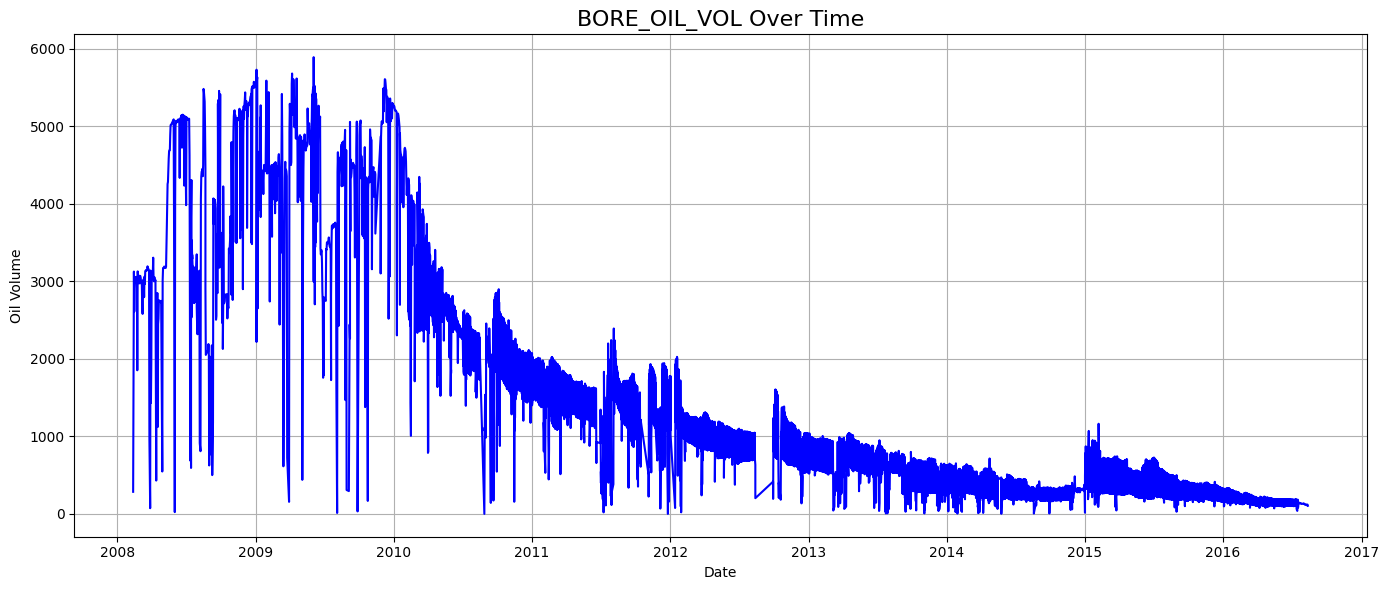

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(df.index, df['BORE_OIL_VOL'], color='blue')
plt.title('BORE_OIL_VOL Over Time', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Oil Volume')
plt.grid(True)
plt.tight_layout()
plt.show()


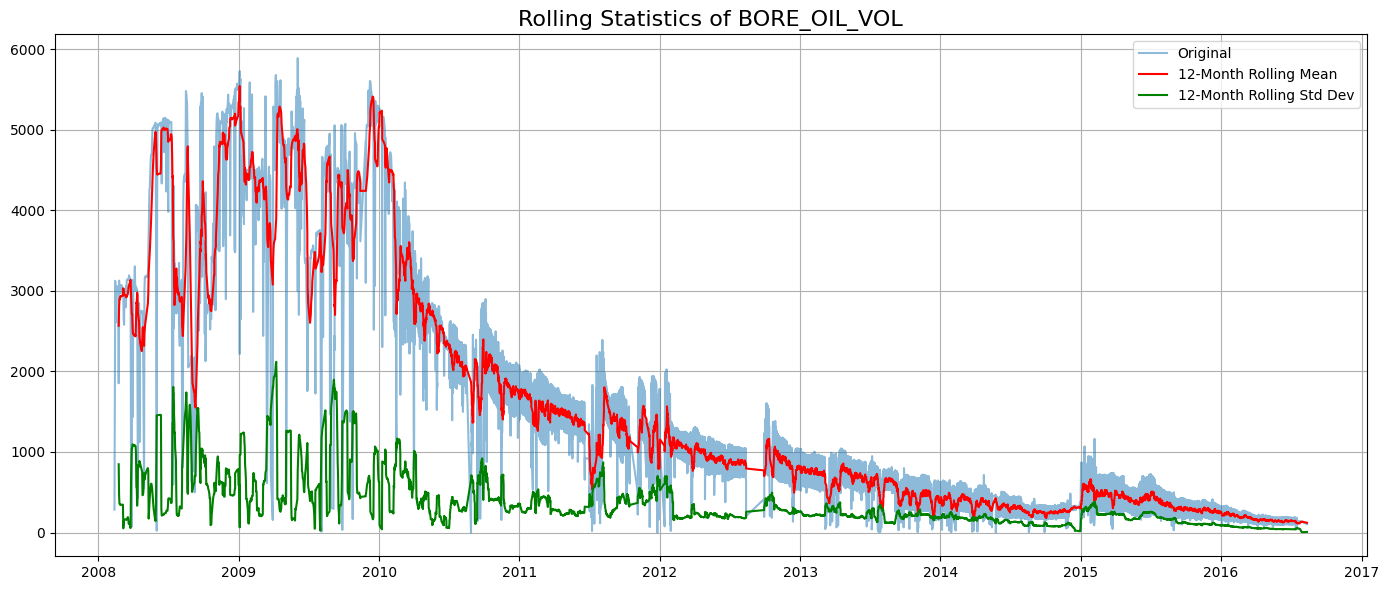

In [5]:
rolling_mean = df['BORE_OIL_VOL'].rolling(window=12).mean()
rolling_std = df['BORE_OIL_VOL'].rolling(window=12).std()

plt.figure(figsize=(14, 6))
plt.plot(df['BORE_OIL_VOL'], label='Original', alpha=0.5)
plt.plot(rolling_mean, label='12-Month Rolling Mean', color='red')
plt.plot(rolling_std, label='12-Month Rolling Std Dev', color='green')
plt.title('Rolling Statistics of BORE_OIL_VOL', fontsize=16)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


<Figure size 1400x1000 with 0 Axes>

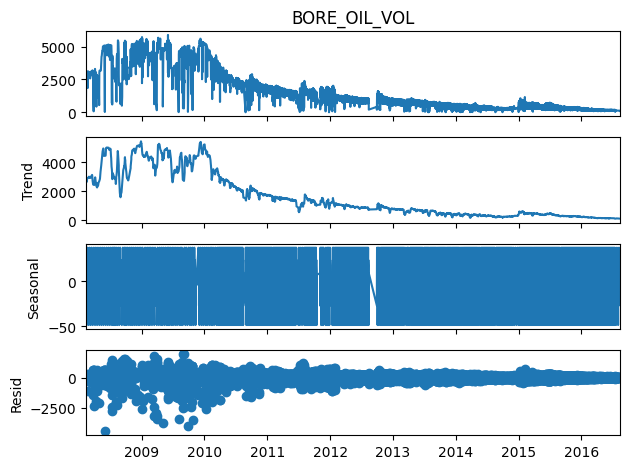

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(df['BORE_OIL_VOL'], model='additive', period=12)

plt.figure(figsize=(14, 10))
decomposition.plot()
plt.tight_layout()
plt.show()


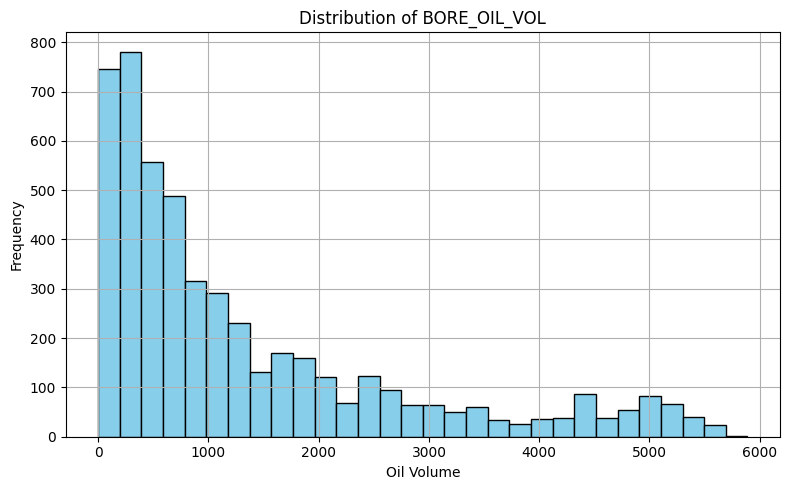

In [7]:
plt.figure(figsize=(8, 5))
plt.hist(df['BORE_OIL_VOL'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of BORE_OIL_VOL')
plt.xlabel('Oil Volume')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()


In [8]:
# Train/Test Split BEFORE scaling
train_size = int(len(full_data) * 0.8)
train_data = full_data[:train_size]
test_data = full_data[train_size:]

# Scale (fit on train only)
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)


In [9]:
# Sequence generator
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

In [10]:


SEQ_LEN = 10
X_train, y_train = create_sequences(train_scaled, SEQ_LEN)
X_test, y_test = create_sequences(test_scaled, SEQ_LEN)

# (Optional) Check shapes
print("X_train:", X_train.shape, "| y_train:", y_train.shape)
print("X_test:", X_test.shape, "| y_test:", y_test.shape)


X_train: (4025, 10, 1) | y_train: (4025, 1)
X_test: (999, 10, 1) | y_test: (999, 1)


In [11]:
# LSTM Model
lstm_model = Sequential()
lstm_model.add(LSTM(64, activation='relu', input_shape=(SEQ_LEN, 1)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

# Train
lstm_model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), callbacks=[EarlyStopping(patience=5)])


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0628 - val_loss: 0.0017
Epoch 2/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0076 - val_loss: 9.9444e-04
Epoch 3/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0079 - val_loss: 7.1876e-04
Epoch 4/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0081 - val_loss: 8.0755e-04
Epoch 5/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0073 - val_loss: 6.0150e-04
Epoch 6/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0082 - val_loss: 5.8226e-04
Epoch 7/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0069 - val_loss: 6.2010e-04
Epoch 8/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0062 - val_loss: 5.8381e-04
Epoch 9/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0068 - val_loss: 0.0014
Epoch 10/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0070 - val_loss: 5.8911e-04
Epoch 11/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0066 - val_loss: 6.2927e-04


In [18]:
bilstm_model = Sequential()
bilstm_model.add(Bidirectional(LSTM(64, activation='relu'), input_shape=(SEQ_LEN, 1)))
bilstm_model.add(Dense(1))
bilstm_model.compile(optimizer='adam', loss='mse')

bilstm_model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), callbacks=[EarlyStopping(patience=5)])


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 0.0376 - val_loss: 9.7894e-04
Epoch 2/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0077 - val_loss: 5.8488e-04
Epoch 3/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0083 - val_loss: 5.7752e-04
Epoch 4/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0085 - val_loss: 5.7089e-04
Epoch 5/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0071 - val_loss: 5.7437e-04
Epoch 6/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0074 - val_loss: 8.4701e-04
Epoch 7/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0070 - val_loss: 5.9137e-04
Epoch 8/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0072 - val_loss: 0.0014
Epoch 9/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0067 - val_loss: 0.0010


In [13]:
# GRU Model
gru_model = Sequential()
gru_model.add(GRU(64, activation='relu', input_shape=(SEQ_LEN, 1)))
gru_model.add(Dense(1))
gru_model.compile(optimizer='adam', loss='mse')

# Train
gru_model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), callbacks=[EarlyStopping(patience=5)])


Epoch 1/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0593 - val_loss: 7.4816e-04
Epoch 2/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0073 - val_loss: 7.3437e-04
Epoch 3/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0074 - val_loss: 6.7970e-04
Epoch 4/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0070 - val_loss: 0.0013
Epoch 5/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0078 - val_loss: 8.4794e-04
Epoch 6/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0067 - val_loss: 6.5513e-04
Epoch 7/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0065 - val_loss: 8.6581e-04
Epoch 8/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0069 - val_loss: 7.1940e-04
Epoch 9/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0065 - val_loss: 9.7902e-04
Epoch 10/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0064 - val_loss: 7.7867e-04
Epoch 11/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0072 - val_loss: 6.9082e-04


In [14]:
bigru_model = Sequential()
bigru_model.add(Bidirectional(GRU(64, activation='relu'), input_shape=(SEQ_LEN, 1)))
bigru_model.add(Dense(1))
bigru_model.compile(optimizer='adam', loss='mse')

bigru_model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), callbacks=[EarlyStopping(patience=5)])


Epoch 1/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0615 - val_loss: 9.0478e-04
Epoch 2/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0078 - val_loss: 7.5816e-04
Epoch 3/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0070 - val_loss: 6.1304e-04
Epoch 4/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0072 - val_loss: 6.1290e-04
Epoch 5/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0069 - val_loss: 6.3748e-04
Epoch 6/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0066 - val_loss: 6.6546e-04
Epoch 7/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0065 - val_loss: 0.0012
Epoch 8/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0067 - val_loss: 7.6199e-04
Epoch 9/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0064 - val_loss: 6.4434e-04


In [16]:
# Reshape input to 5D: (samples, time steps, rows, cols, channels)
# Concatenate X_train and X_test to recreate X
X = np.concatenate((X_train, X_test))
X_conv = X.reshape((X.shape[0], 1, 1, SEQ_LEN, 1))
X_train_conv, X_test_conv = X_conv[:len(X_train)], X_conv[len(X_train):]

conv_lstm_model = Sequential()
conv_lstm_model.add(ConvLSTM2D(filters=32, kernel_size=(1, 3), activation='relu', input_shape=(1, 1, SEQ_LEN, 1)))
conv_lstm_model.add(Flatten())
conv_lstm_model.add(Dense(1))
conv_lstm_model.compile(optimizer='adam', loss='mse')

conv_lstm_model.fit(X_train_conv, y_train, epochs=20, validation_data=(X_test_conv, y_test), callbacks=[EarlyStopping(patience=5)])

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.0794 - val_loss: 0.0060
Epoch 2/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0089 - val_loss: 0.0012
Epoch 3/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0085 - val_loss: 0.0011
Epoch 4/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0075 - val_loss: 8.5882e-04
Epoch 5/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0078 - val_loss: 7.4122e-04
Epoch 6/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0074 - val_loss: 9.0308e-04
Epoch 7/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0080 - val_loss: 6.4291e-04
Epoch 8/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0069 - val_loss: 7.0099e-04
Epoch 9/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0081 - val_loss: 6.8125e-04
Epoch 10/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0069 - val_loss: 8.4522e-04
Epoch 11/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0072 - val_loss: 5.8081e-04
Epoch 12/20
126/126 ━━━━━━━━

In [17]:
def plot_predictions(model, X, y, is_conv=False):
    if is_conv:
        X = X.reshape((X.shape[0], 1, 1, SEQ_LEN, 1))
    preds = model.predict(X)
    preds_inv = scaler.inverse_transform(preds)
    y_inv = scaler.inverse_transform(y)

    plt.figure(figsize=(10, 5))
    plt.plot(y_inv, label='Actual')
    plt.plot(preds_inv, label='Predicted')
    plt.legend()
    plt.title('Prediction vs Actual')
    plt.show()

# Example usage:


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


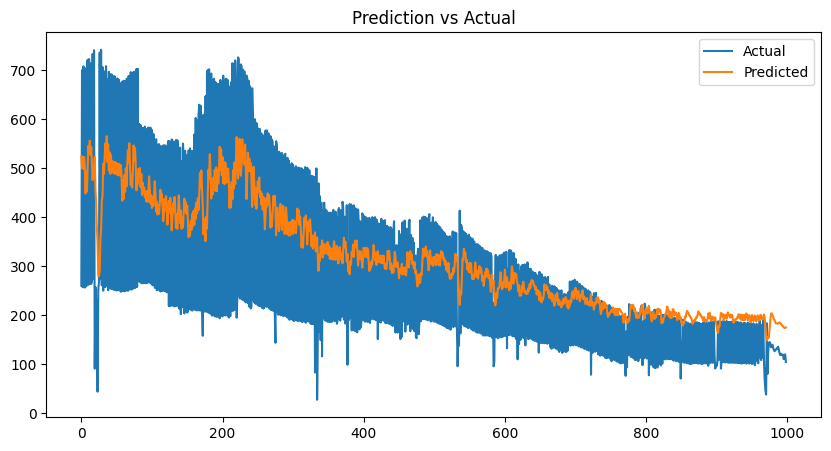

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


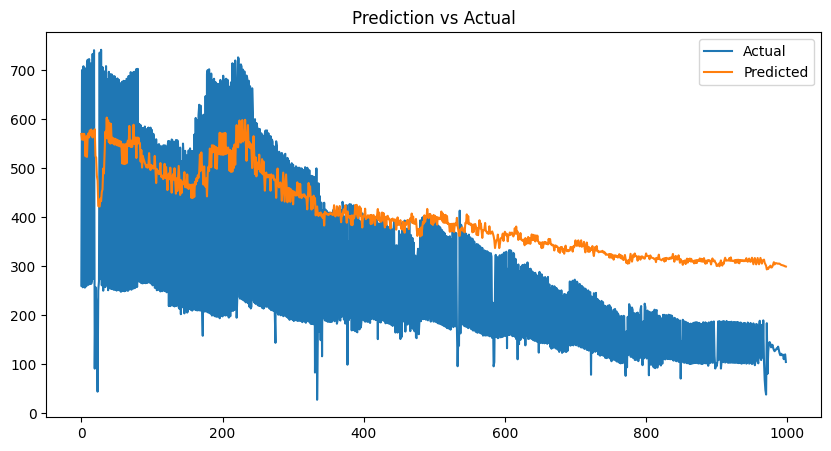

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


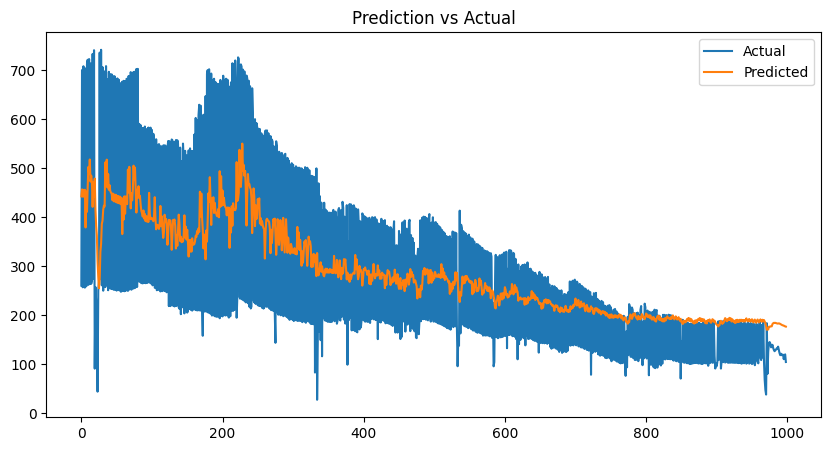

In [19]:
plot_predictions(lstm_model, X_test, y_test)
plot_predictions(bilstm_model, X_test, y_test)
plot_predictions(conv_lstm_model, X_test, y_test, is_conv=True)


# STACKED

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

stacked_lstm_model = Sequential()
stacked_lstm_model.add(LSTM(64, activation='relu', return_sequences=True, input_shape=(SEQ_LEN, 1)))
stacked_lstm_model.add(LSTM(32, activation='relu'))
stacked_lstm_model.add(Dense(1))
stacked_lstm_model.compile(optimizer='adam', loss='mse')

stacked_lstm_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, callbacks=[EarlyStopping(patience=5)])


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0443 - val_loss: 0.0010
Epoch 2/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0086 - val_loss: 9.1409e-04
Epoch 3/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0087 - val_loss: 7.8435e-04
Epoch 4/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0083 - val_loss: 6.6711e-04
Epoch 5/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0078 - val_loss: 5.5444e-04
Epoch 6/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0068 - val_loss: 5.7859e-04
Epoch 7/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0080 - val_loss: 6.4002e-04
Epoch 8/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0070 - val_loss: 5.6558e-04
Epoch 9/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0073 - val_loss: 7.8311e-04
Epoch 10/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0068 - val_loss: 8.8041e-04


In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense

stacked_gru_model = Sequential()
stacked_gru_model.add(GRU(64, activation='relu', return_sequences=True, input_shape=(SEQ_LEN, 1)))
stacked_gru_model.add(GRU(32, activation='relu'))
stacked_gru_model.add(Dense(1))
stacked_gru_model.compile(optimizer='adam', loss='mse')

stacked_gru_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, callbacks=[EarlyStopping(patience=5)])


Epoch 1/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.0367 - val_loss: 8.3574e-04
Epoch 2/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0070 - val_loss: 7.3235e-04
Epoch 3/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0065 - val_loss: 0.0012
Epoch 4/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0069 - val_loss: 6.0681e-04
Epoch 5/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0065 - val_loss: 6.3696e-04
Epoch 6/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0078 - val_loss: 9.1846e-04
Epoch 7/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0074 - val_loss: 6.5494e-04
Epoch 8/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0069 - val_loss: 0.0011
Epoch 9/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0062 - val_loss: 6.7335e-04


In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, Flatten, Dense

# Reshape for ConvLSTM: (samples, time steps, rows, cols, channels)
X_train_conv = X_train.reshape((X_train.shape[0], 1, 1, SEQ_LEN, 1))
X_test_conv = X_test.reshape((X_test.shape[0], 1, 1, SEQ_LEN, 1))

stacked_convlstm_model = Sequential()
stacked_convlstm_model.add(ConvLSTM2D(filters=32, kernel_size=(1, 3), activation='relu',
                                      return_sequences=True, input_shape=(1, 1, SEQ_LEN, 1)))
stacked_convlstm_model.add(ConvLSTM2D(filters=16, kernel_size=(1, 3), activation='relu'))
stacked_convlstm_model.add(Flatten())
stacked_convlstm_model.add(Dense(1))
stacked_convlstm_model.compile(optimizer='adam', loss='mse')

stacked_convlstm_model.fit(X_train_conv, y_train, validation_data=(X_test_conv, y_test), epochs=20, callbacks=[EarlyStopping(patience=5)])


Epoch 1/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.0788 - val_loss: 0.0050
Epoch 2/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0110 - val_loss: 0.0023
Epoch 3/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0091 - val_loss: 0.0014
Epoch 4/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0098 - val_loss: 0.0010
Epoch 5/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0084 - val_loss: 0.0016
Epoch 6/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0081 - val_loss: 7.2873e-04
Epoch 7/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0080 - val_loss: 6.6753e-04
Epoch 8/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0067 - val_loss: 7.1528e-04
Epoch 9/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0071 - val_loss: 0.0011
Epoch 10/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0069 - val_loss: 5.4325e-04
Epoch 11/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0067 - val_loss: 7.3631e-04
Epoch 12/20
126/126 ━━━━━━━━━

In [23]:
import matplotlib.pyplot as plt

def plot_predictions(model, X, y, scaler, is_conv=False, title='Prediction vs Actual'):
    """
    Plot actual vs predicted values.
    """
    if is_conv:
        X = X.reshape((X.shape[0], 1, 1, SEQ_LEN, 1))
    else:
        X = X.reshape((X.shape[0], SEQ_LEN, 1))

    predictions = model.predict(X)

    # Inverse scale predictions and targets
    y_pred_inv = scaler.inverse_transform(predictions)
    y_true_inv = scaler.inverse_transform(y)

    # Plot
    plt.figure(figsize=(12, 5))
    plt.plot(y_true_inv, label='Actual', color='black')
    plt.plot(y_pred_inv, label='Predicted', color='red')
    plt.title(title)
    plt.xlabel('Time Step')
    plt.ylabel('BORE_OIL_VOL')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


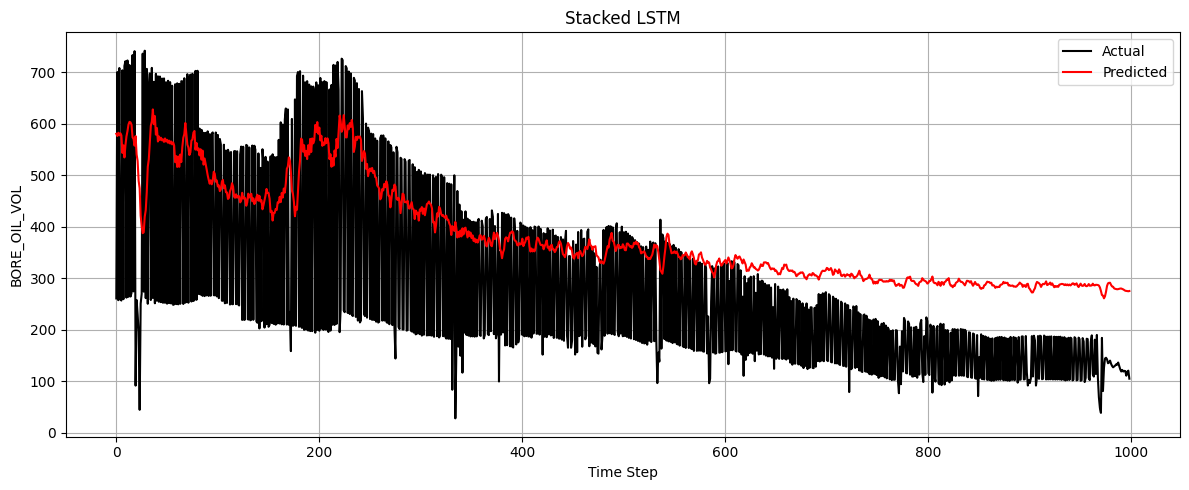

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


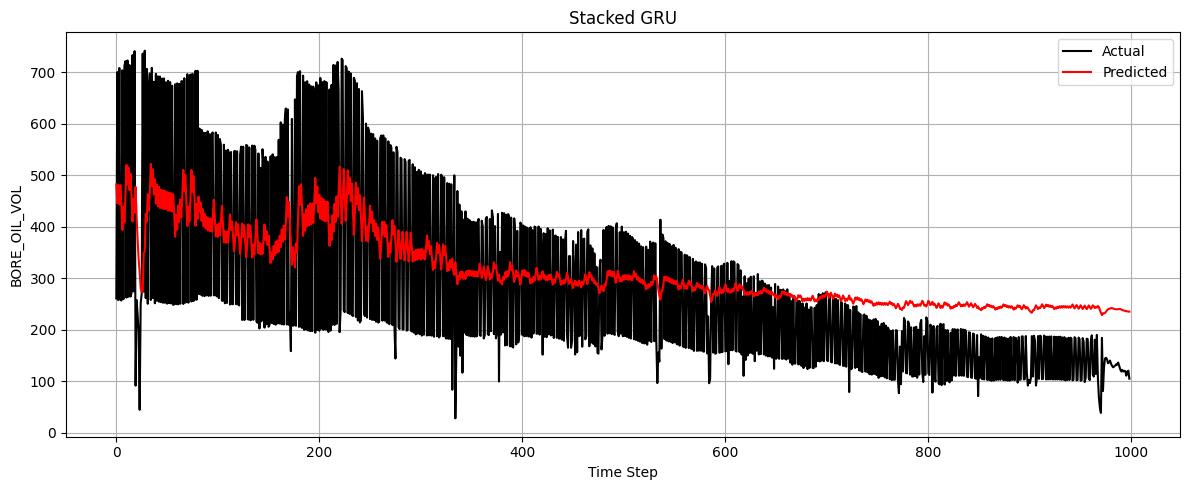

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


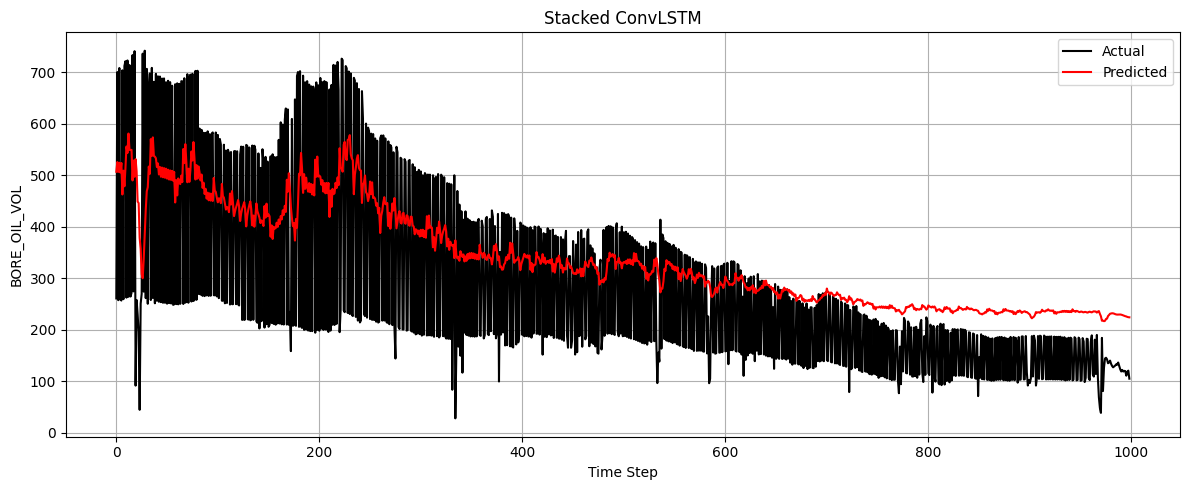

In [24]:
# For stacked LSTM
plot_predictions(stacked_lstm_model, X_test, y_test, scaler, is_conv=False, title='Stacked LSTM')

# For stacked GRU
plot_predictions(stacked_gru_model, X_test, y_test, scaler, is_conv=False, title='Stacked GRU')

# For stacked ConvLSTM
plot_predictions(stacked_convlstm_model, X_test, y_test, scaler, is_conv=True, title='Stacked ConvLSTM')
